In [4]:
%load_ext autoreload
%autoreload 2

import os
import sys
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Region Identification

<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<title>Flood Statistics Grid</title>
<style>
    .grid-container {
        display: grid;
        grid-template-columns: repeat(2, 1fr);
        gap: 20px;
    }
    figure {
        margin: 0;
        padding: 0;
        text-align: center;
    }
    figcaption {
        margin-top: 10px;
        font-style: italic;
    }
</style>
</head>
<body>
<div class="grid-container">
    <figure>
       <img src="images/flooding_fatality_stats.png" width="100%" />
       <figcaption>Countries with the highest flood mortality by flood type [1]</figcaption>
    </figure>
    <figure>
       <img src="images/countries_most_freq.png" width="100%" />
       <figcaption>Countries with the highest flood frequency [1]</figcaption>
    </figure>
    <figure>
       <img src="images/annual_loss_gdp.png" width="100%" />
       <figcaption>Annual expected losses as percent of GDP for NatCat events [2]</figcaption>
    </figure>
    <figure>
       <img src="images/underinsurance.png" width="100%" />
       <figcaption>Global overview of countries underinsurance risk as percentage of GDP for NatCat events [2]</figcaption>
    </figure>
</div>
</body>
</html>

Based on the above investigation, the following region was identified for developing the model:
- Bangladesh


# Region Definition and Analysis

In [5]:
REGIONS = ["Bangladesh",]# "Vietnam", "India"]
DATA_DOWNLOAD_DIR = "./data"

# Data Aquisition and Preprocessing

In this section we download all the dataset we need for feature engineering and modeling. This includes:
- Global Flood Database inundation maps for historical events
- JRC Flood Hazard maps
- Sentinel 1 orbit files for the dates of the flood events
- Sentinel 1 footprints for the dates of previous acquisitions

In [36]:
from global_flood_db import download_data_for

region_events = {}

for country in tqdm(REGIONS):
    df_events = download_data_for(DATA_DOWNLOAD_DIR, country_name=country, download_region_bounds=True, progress_bar=tqdm, download_all=False)
    region_events[country] = df_events


Create a default grid at 1x1 km resolution for the ROI, we will use this to download and process all data to.

ASSUMPTION: We will use a 1x1km grid for computational efficiency. This should be sufficiently dense still as Sentinel-1 has a 250km swath.

In [ ]:
import os
from helpers import create_region_mask_and_grid, load_poly_from_geojson

grids = {}

for country in tqdm(REGIONS):
    download_dir = os.path.join(DATA_DOWNLOAD_DIR, country)
    country_geom = load_poly_from_geojson(os.path.join(DATA_DOWNLOAD_DIR, country, f"{country}.geojson"))
    transform, width, height = create_region_mask_and_grid(
        country_geom, 
        resolution=1000,
        output_path=os.path.join(DATA_DOWNLOAD_DIR, country, f"{country}_grid.tif")
    )

    grids[country] = {
        "width": width,
        "height": height,
        "transform": transform,
    }

Download the JRC flood hazard maps for the flood event periods of 10, 50, 100, 200 and 500 years.

In [173]:
import os
from helpers import load_poly_from_geojson
from glofas_flood_hazard import download_flood_hazard_map_for_geometry, FLOOD_EVENT_PERIODS
from helpers import open_on_grid
from rasterio.enums import Resampling

for country in tqdm(REGIONS):
    for event in tqdm(FLOOD_EVENT_PERIODS):
        download_dir = os.path.join(DATA_DOWNLOAD_DIR, country)
        country_geom = load_poly_from_geojson(os.path.join(DATA_DOWNLOAD_DIR, country, f"{country}.geojson"))
        flood_hazard_map = download_flood_hazard_map_for_geometry(download_dir, country_geom, flood_event_type=f"RP{event}", progress_bar=tqdm)

        grid_path = os.path.join(DATA_DOWNLOAD_DIR, country, f"{country}_grid.tif")
        output_path = os.path.join(DATA_DOWNLOAD_DIR, country, f"flood_hazard_RP{event}_grid.tif")

        # Project the flood_hazard map to the grid
        with open_on_grid(flood_hazard_map, grid_path, Resampling.max, crop_to=country_geom, save_to=output_path) as flood_hazard:
            pass

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Download SRTM 30 arc-second DEM and process it to EPSG:4326 on the common grid we created earlier

In [16]:
import os
import elevation

from helpers import open_on_grid, load_poly_from_geojson
from rasterio.enums import Resampling

for country in tqdm(REGIONS):
    download_dir = os.path.join(DATA_DOWNLOAD_DIR, country)
    dem_path = os.path.join(download_dir, "dem.tif")

    if not os.path.exists(dem_path):
        country_geom = load_poly_from_geojson(os.path.join(DATA_DOWNLOAD_DIR, country, f"{country}.geojson"))
        minx, miny, maxx, maxy = country_geom.bounds

        !eio --product SRTM3 clip -o {dem_path}  --bounds {minx} {miny} {maxx} {maxy}
    
    if os.path.exists(dem_path):
        grid_path = os.path.join(DATA_DOWNLOAD_DIR, country, f"{country}_grid.tif")
        output_path = os.path.join(DATA_DOWNLOAD_DIR, country, f"dem_grid.tif")

        # Project the flood_hazard map to the grid
        with open_on_grid(dem_path, grid_path, Resampling.bilinear, crop_to=country_geom, save_to=output_path, invert=True) as dem:
            pass
    

  0%|          | 0/3 [00:00<?, ?it/s]

Download the Sentinel-1 metadata and create the revisit histograms for each flood event
- We use 30 days prior to the flood event to analyse revisit times
- We create a map of which pixels were acquired by S1 within 24hours from the start of the event

In [253]:
from sentinel1 import EPOCH_SENTINEL1, get_sentinel1_acquisitions_meta, create_sentinel_revisit_map, get_average_revisit, sentinel1_acquired
import pandas as pd

for country in REGIONS:
    base_dir = os.path.join(DATA_DOWNLOAD_DIR, country)

    flood_events = pd.read_csv(
            os.path.join(base_dir, "flood_events.csv"),
            parse_dates=["start_date", "end_date"],
        )

    s1_path = os.path.join(base_dir, "sentinel1")
    os.makedirs(s1_path, exist_ok=True)

    for _, row in tqdm(flood_events.iterrows(), total=len(flood_events)):
        # Make revisit map for the 30 days prior to the flood event
        revisit_path = os.path.join(s1_path, f"{row['event_id']}_revisit.tif")
        if not os.path.exists(revisit_path):
            items = get_sentinel1_acquisitions_meta(DATA_DOWNLOAD_DIR, country, row["start_date"], days_before=30)
            revisit_histogram_da = create_sentinel_revisit_map(DATA_DOWNLOAD_DIR, country, items, save_to=revisit_path)
        
        # Captured within 24 hours of the start of the flood
        captured_path = os.path.join(s1_path, f"{row['event_id']}_24hr.tif")
        if not os.path.exists(captured_path):
            items = get_sentinel1_acquisitions_meta(DATA_DOWNLOAD_DIR, country, row["start_date"], days_before=-1)
            captured_flood = sentinel1_acquired(DATA_DOWNLOAD_DIR, country, items, save_to=captured_path)

  0%|          | 0/23 [00:00<?, ?it/s]

# Feature Engineering and Investigation

In this section we deal with create features and analyzing relationships between various properties

ASSUMPTION: All events prior to Aug 2017 are form part of the training dataset. Feature engineering only happens on the training data

In [6]:
import os

feature_dir = {}
for country in tqdm(REGIONS):
    feature_dir[country] = os.path.join(DATA_DOWNLOAD_DIR, country, "derived")
    os.makedirs(feature_dir[country], exist_ok=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

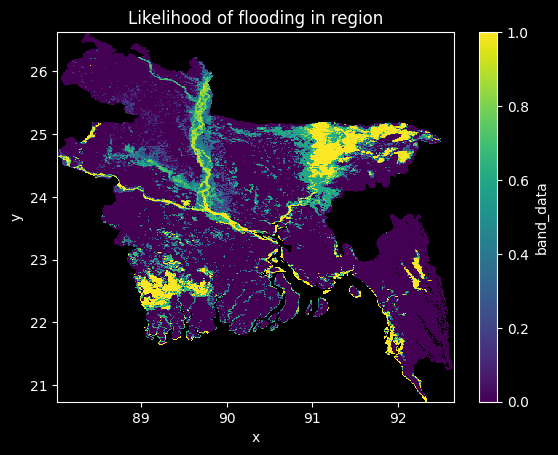

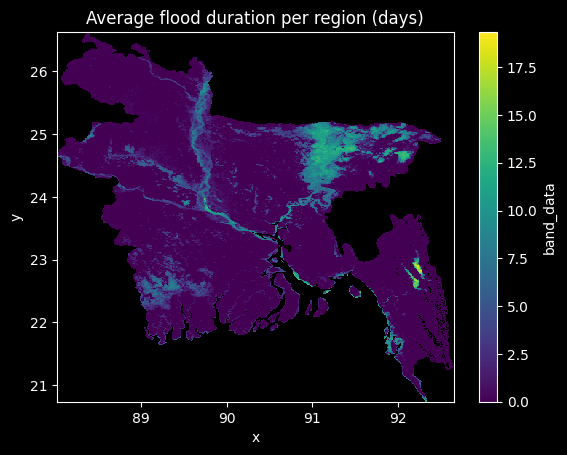

In [75]:
import os
from global_flood_db import accumulate_data

for country in tqdm(REGIONS):
    historic_flood_stats = accumulate_data(DATA_DOWNLOAD_DIR, country, progress_bar=tqdm, save_to_disk=True, subset="train")

    prob_flooded = historic_flood_stats.isel(band=0)/historic_flood_stats.isel(band=2)
    plt.figure()
    prob_flooded.plot()
    _=plt.title("Likelihood of flooding in region")
    prob_flooded.rio.to_raster(os.path.join(feature_dir[country], "flood_prob.tif"))

    avg_duration = historic_flood_stats.isel(band=1)/historic_flood_stats.isel(band=2)
    plt.figure()
    avg_duration.plot()
    _=plt.title("Average flood duration per region (days)")
    avg_duration.rio.to_raster(os.path.join(feature_dir[country], "avg_duration.tif"))


Compute the flooded probability using the outputs of the JRC hydrological model

  0%|          | 0/1 [00:00<?, ?it/s]

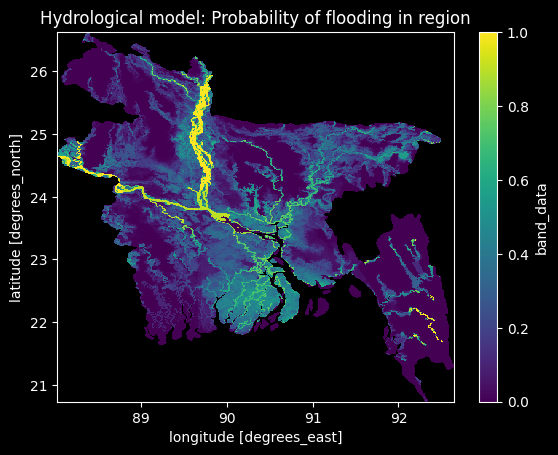

In [76]:
from glofas_flood_hazard import compute_flood_probability_map

for country in tqdm(REGIONS):
    prob_flooded_hydro = compute_flood_probability_map(DATA_DOWNLOAD_DIR, country)
    plt.figure()
    prob_flooded_hydro.plot()
    _=plt.title("Hydrological model: Probability of flooding in region")
    prob_flooded.rio.to_raster(os.path.join(feature_dir[country], "flood_prob_jrc.tif"))

Compute the overall per-pixel histogram of Sentinel-1 revisit times based on the previous flooding events 

  0%|          | 0/17 [00:00<?, ?it/s]

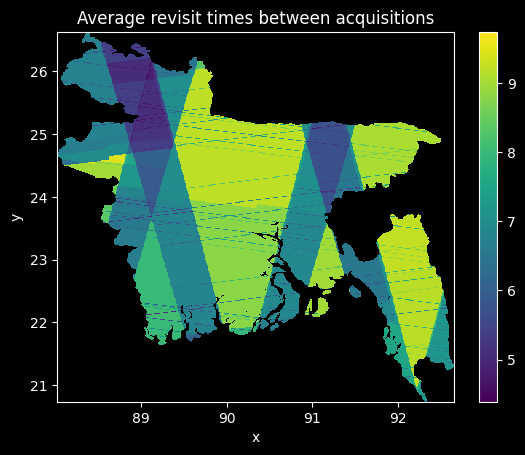

In [138]:
from helpers import load_flood_events
from sentinel1 import get_average_revisit
import xarray as xr

subset="train"
for country in REGIONS:
    base_dir = os.path.join(DATA_DOWNLOAD_DIR, country)

    # Only use the training subset for 
    flood_events = load_flood_events(DATA_DOWNLOAD_DIR, country, subset=subset)
    
    s1_path = os.path.join(base_dir, "sentinel1")

    acc_hist = None

    for _, row in tqdm(flood_events.iterrows(), total=len(flood_events)):
        # Make revisit map for the 30 days prior to the flood event
        revisit_path = os.path.join(s1_path, f"{row['event_id']}_revisit.tif")
        revisits = xr.open_dataarray(revisit_path, engine="rasterio")
        revisits = revisits.rename({'band':'days'})
        revisits = revisits.fillna(0)

        if acc_hist is None:
            acc_hist = revisits
        else:
            acc_hist += revisits

    get_average_revisit(acc_hist).plot()
    _=plt.title("Average revisit times between acquisitions")
    acc_hist.rio.to_raster(os.path.join(feature_dir[country], f"s1_revisit_hist_{subset}.tif"))

Let's analyze the relationship between flooded pixels and the Sentinel-1 revisit times

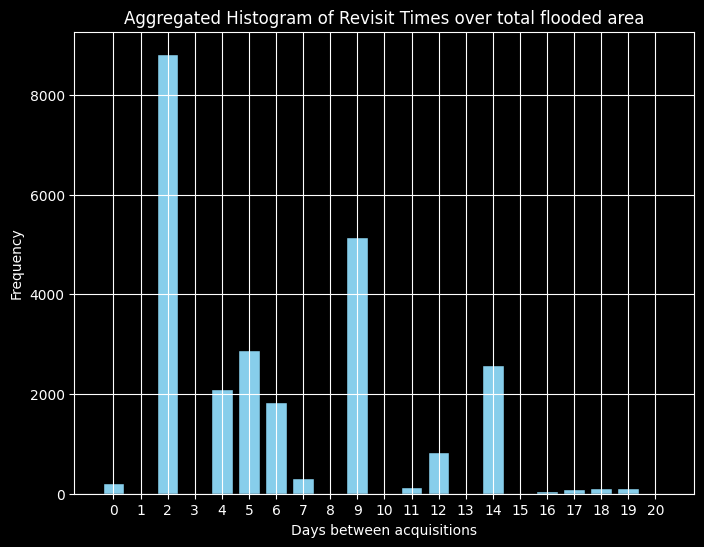

In [30]:
import numpy as np
import random

sentinel1_revisit_map = xr.open_dataarray(os.path.join(feature_dir[country], "s1_revisit_hist_train.tif"), engine="rasterio")
flood_map = xr.open_dataarray(os.path.join(feature_dir[country], "flood_prob.tif"), engine="rasterio")
flooded_pixels = (flood_map.isel(band=0) > 0)

# Randomly select a subset of flooded pixels for sampling
sampled_flooded_pixels = random.sample(list(zip(*np.where(flooded_pixels))), 1000)

# Initialize an array to store the aggregated histogram of revisit times
aggregated_histogram = np.zeros(21)

for y, x in sampled_flooded_pixels:
    revisit_histogram = sentinel1_revisit_map.isel(y=y, x=x).values
    aggregated_histogram += revisit_histogram

plt.figure(figsize=(8, 6))
plt.bar(range(21), aggregated_histogram, color='skyblue', edgecolor='black')
plt.xlabel('Days between acquisitions')
plt.ylabel('Frequency')
plt.xticks(range(21))
plt.title('Aggregated Histogram of Revisit Times over total flooded area')
plt.grid(True)
plt.show()



Santity check of the above by looking at the flood events independantly.

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

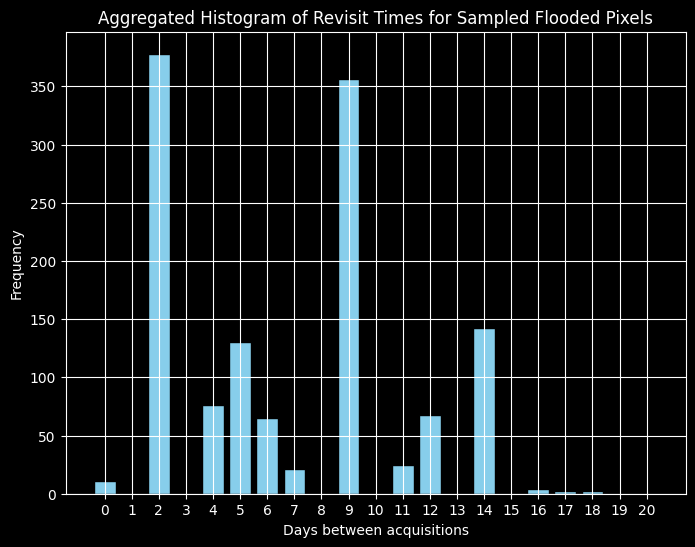

In [29]:
from helpers import open_on_grid, load_poly_from_geojson
from rasterio.enums import Resampling

for country in tqdm(REGIONS):
    flood_events = load_flood_events(DATA_DOWNLOAD_DIR, country, subset="train")

    base_dir = os.path.join(DATA_DOWNLOAD_DIR, country)
    country_geom = load_poly_from_geojson(os.path.join(DATA_DOWNLOAD_DIR, country, f"{country}.geojson"))
    grid_path = os.path.join(DATA_DOWNLOAD_DIR, country, f"{country}_grid.tif")

    aggregated_histogram = np.zeros(21)
    for _, row in tqdm(flood_events.iterrows()):
        s1_path = os.path.join(base_dir, "sentinel1", f"{row['event_id']}_revisit.tif")

        sentinel1_revisit_map = xr.open_dataarray(s1_path, engine="rasterio")

        with open_on_grid(row['flood'], grid_path, Resampling.max, crop_to=country_geom) as flood_map:
            flooded_pixels = (flood_map.isel(band=0) > 0)
             
            # Randomly select a subset of flooded pixels for sampling
            sampled_flooded_pixels = random.sample(list(zip(*np.where(flooded_pixels))), 50)
       
            for y, x in sampled_flooded_pixels:
                revisit_histogram = sentinel1_revisit_map.isel(y=y, x=x).values
                aggregated_histogram += revisit_histogram
        
        sentinel1_revisit_map.close()

    plt.figure(figsize=(8, 6))
    plt.bar(range(21), aggregated_histogram, color='skyblue', edgecolor='black')
    plt.xlabel('Days between acquisitions')
    plt.ylabel('Frequency')
    plt.xticks(range(21))
    plt.title('Aggregated Histogram of Revisit Times for Sampled Flooded Pixels')
    plt.grid(True)
    plt.show()



sentinel1_revisit_map

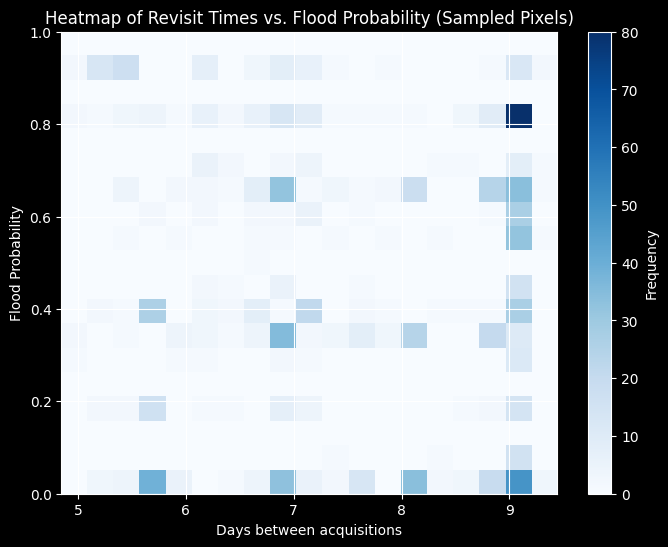

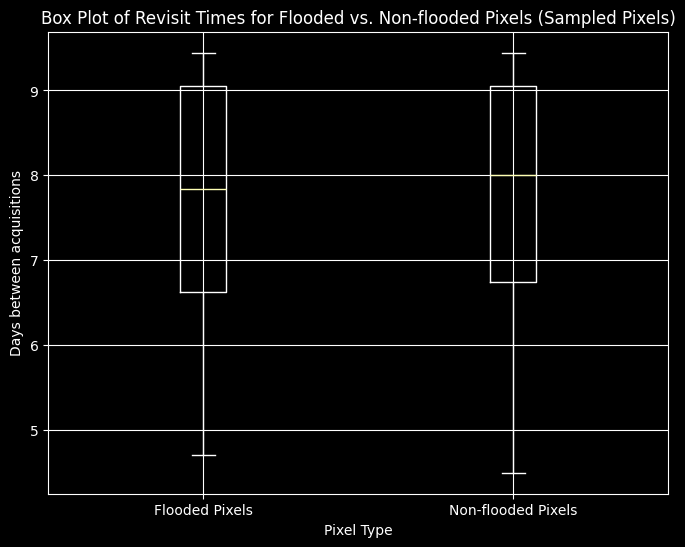

In [166]:

for country in REGIONS:
    revisit_times = []
    flood_frequency = []

    sentinel1_revisit_map = xr.open_dataarray(os.path.join(feature_dir[country], "s1_revisit_hist_train.tif"), engine="rasterio")
    sentinel1_revisit_map = sentinel1_revisit_map.rename({'band':'days'})
    sentinel1_revisit_map = get_average_revisit(sentinel1_revisit_map)
    historic_flood_stats = xr.open_dataarray(os.path.join(feature_dir[country], "flood_prob.tif"), engine="rasterio")
    flooded_pixels = (historic_flood_stats.isel(band=0) > 0)

    sampled_flooded_pixels = random.sample(list(zip(*np.where(flooded_pixels))), 1000)

    for y, x in sampled_flooded_pixels:
        revisit_times.append(sentinel1_revisit_map.isel(y=y, x=x).values)
        flood_frequency.append(historic_flood_stats.isel(band=0, y=y, x=x).values)

    revisit_times_bins = np.linspace(np.min(revisit_times), np.max(revisit_times), 20)
    flood_probability_bins = np.linspace(0, 1, 20)

    # Create 2D histogram
    histogram, x_edges, y_edges = np.histogram2d(revisit_times, flood_frequency, bins=[revisit_times_bins, flood_probability_bins])

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(histogram.T, extent=[np.min(revisit_times), np.max(revisit_times), 0, 1], aspect='auto', cmap='Blues', interpolation='nearest')
    plt.colorbar(label='Frequency')
    plt.xlabel('Days between acquisitions')
    plt.ylabel('Flood Probability')
    plt.title('Heatmap of Revisit Times vs. Flood Probability (Sampled Pixels)')
    plt.grid(True)
    plt.show()


    non_flooded_pixels_indices = np.where(~flooded_pixels & ~np.isnan(sentinel1_revisit_map))
    sampled_flooded_pixels = random.sample(list(zip(*np.where(flooded_pixels))), 1000)
    sampled_non_flooded_pixels = random.sample(list(zip(*non_flooded_pixels_indices)), 1000)

    # Collect revisit times for flooded and non-flooded pixels
    revisit_times_flooded = []
    revisit_times_non_flooded = []

    for y, x in sampled_flooded_pixels:
        revisit_times_flooded.append(sentinel1_revisit_map.isel(y=y, x=x).values)

    for y, x in sampled_non_flooded_pixels:
        revisit_times_non_flooded.append(sentinel1_revisit_map.isel(y=y, x=x).values)

    # Plot the box plot
    plt.figure(figsize=(8, 6))
    plt.boxplot([revisit_times_flooded, revisit_times_non_flooded], labels=['Flooded Pixels', 'Non-flooded Pixels'])
    plt.xlabel('Pixel Type')
    plt.ylabel('Days between acquisitions')
    plt.title('Box Plot of Revisit Times for Flooded vs. Non-flooded Pixels (Sampled Pixels)')
    plt.grid(True)
    plt.show()

    sentinel1_revisit_map.close()
    historic_flood_stats.close()

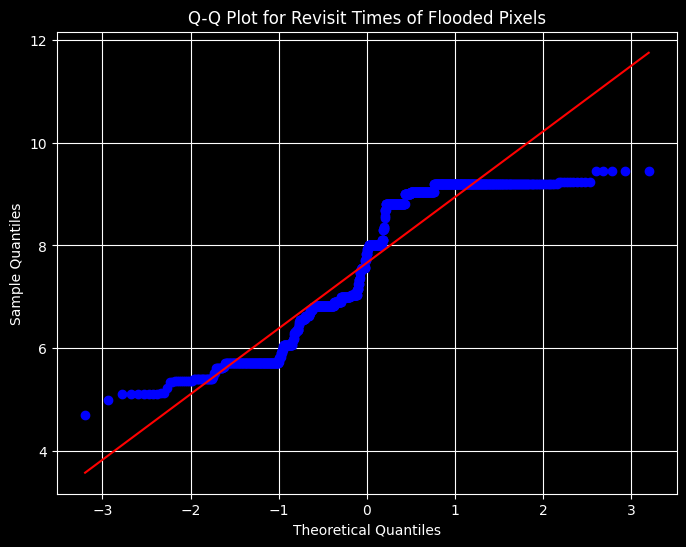

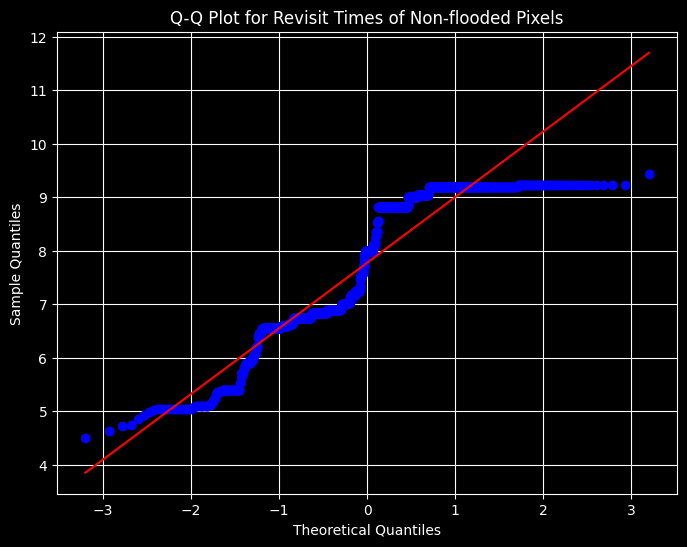

In [167]:
from scipy import stats

# t_statistic, p_value = stats.ttest_ind(revisit_times_flooded, revisit_times_non_flooded)

plt.figure(figsize=(8, 6))
stats.probplot(revisit_times_flooded, dist="norm", plot=plt)
plt.title('Q-Q Plot for Revisit Times of Flooded Pixels')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

# Create Q-Q plot for non-flooded pixels
plt.figure(figsize=(8, 6))
stats.probplot(revisit_times_non_flooded, dist="norm", plot=plt)
plt.title('Q-Q Plot for Revisit Times of Non-flooded Pixels')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

As the data is multimodal and not-normally distributed, we cannot use t-test.

We could try ks-test but it is not well suited to differences in sample size which could occur due to the difference in spatial extent between areas flooded and those which are not.

We can compute the Earth movers distance to confirm that the difference between distributions is small in terms of energy

In [170]:
from scipy.stats import wasserstein_distance

wd = wasserstein_distance(revisit_times_flooded, revisit_times_non_flooded)
print("Wasserstein Distance:", wd)

Wasserstein Distance: 0.16249544203342314


## Flood characteristics

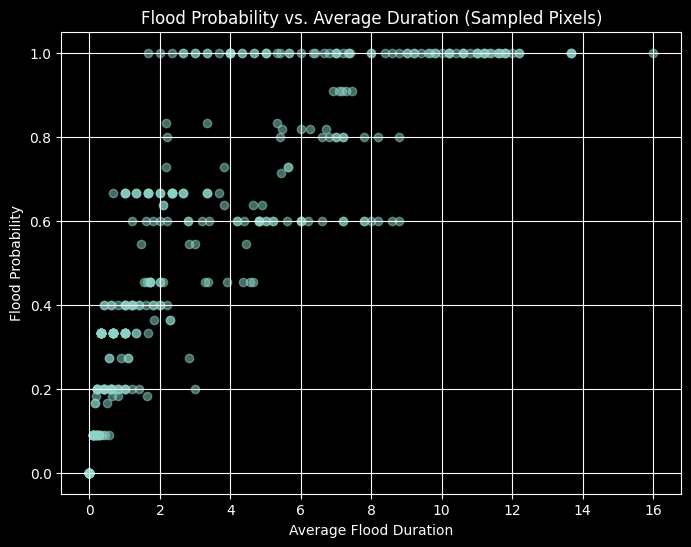

  0%|          | 0/17 [00:00<?, ?it/s]

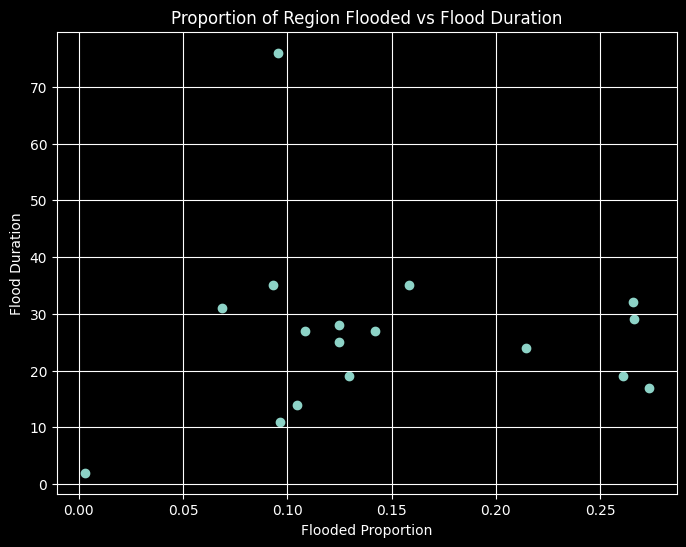

In [78]:
import random
from helpers import open_on_grid, load_poly_from_geojson
from rasterio.enums import Resampling

for country in REGIONS:
    flood_prob = xr.open_dataarray(os.path.join(feature_dir[country], "flood_prob.tif"), engine="rasterio")
    flood_avg_duration = xr.open_dataarray(os.path.join(feature_dir[country], "avg_duration.tif"), engine="rasterio")

    num_samples = 1000
    valid_indices = np.where(~np.isnan(flood_prob) & ~np.isnan(flood_avg_duration))
    sampled_indices = random.sample(list(zip(*valid_indices)), min(num_samples, len(valid_indices[0])))

    flood_probability_values = [flood_prob.values[idx] for idx in sampled_indices]
    average_duration_values = [flood_avg_duration.values[idx] for idx in sampled_indices]

    # Plot the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(average_duration_values, flood_probability_values, alpha=0.5)
    plt.xlabel('Average Flood Duration')
    plt.ylabel('Flood Probability')
    plt.title('Flood Probability vs. Average Duration (Sampled Pixels)')
    plt.grid(True)
    plt.show()


    flood_events = load_flood_events(DATA_DOWNLOAD_DIR, country, subset="train")

    base_dir = os.path.join(DATA_DOWNLOAD_DIR, country)
    country_geom = load_poly_from_geojson(os.path.join(DATA_DOWNLOAD_DIR, country, f"{country}.geojson"))
    grid_path = os.path.join(DATA_DOWNLOAD_DIR, country, f"{country}_grid.tif")

    flood_size = []
    flood_duration = []
    flood_proportion = []
    for i, row in tqdm(flood_events.iterrows(), total=len(flood_events)):
        with open_on_grid(row['flood'], grid_path, Resampling.max, crop_to=country_geom) as flood_map:
            flood_size.append((flood_map.isel(band=0)>0).sum().values)
            flood_duration.append((row['end_date']-row['start_date']).days)
            flood_proportion.append((flood_size[-1]/(flood_map.isel(band=2)>0).sum()).values)

    plt.figure(figsize=(8, 6))
    plt.scatter(flood_proportion, flood_duration)
    plt.xlabel('Flooded Proportion')
    plt.ylabel('Flood Duration')
    plt.title('Proportion of Region Flooded vs Flood Duration')
    plt.grid(True)
    plt.show()

# Model Development

In this section we will:
- Create training and test datasets
- Train logistic regression model

### Dataset creation

In [11]:
from helpers import open_on_grid, load_poly_from_geojson, load_flood_events
from sentinel1 import get_average_revisit
import xarray as xr
import numpy as np
import random
from rasterio.enums import Resampling

def encode_seasonality(start_date):
    month = start_date.month
    
    # Encode month as cyclic feature
    angle = 2 * np.pi * (month - 1) / 12  # Convert month to angle in radians
    cyclic_feature = np.array([np.cos(angle), np.sin(angle)])
    
    return cyclic_feature

def compute_cumsum(revisit_histogram):
    cumulative_probabilities = np.cumsum(revisit_histogram)

    if cumulative_probabilities[-1] == 0:
        return None

    cumulative_probabilities /= cumulative_probabilities[-1]
    
    return cumulative_probabilities

def compute_prob_of_acq_today(revisit_histogram, days_since_acq):
    cumulative_probabilities = compute_cumsum(revisit_histogram)

    if cumulative_probabilities is None:
        revisit_histogram = np.ones(21)
        cumulative_probabilities = compute_cumsum(revisit_histogram)

    return cumulative_probabilities[int(days_since_acq)]

def extract_features_and_target(df_events, download_dir:str, country:str, num_samples_per_class: int=1000, subset: str = "train"):
    X = []
    Y = []
    
    base_dir = os.path.join(download_dir, country)
    country_geom = load_poly_from_geojson(os.path.join(base_dir, f"{country}.geojson"))
    grid_path = os.path.join(base_dir, f"{country}_grid.tif")

    hydro_flood_prob_path = os.path.join(base_dir, "derived", "flood_prob_jrc.tif")
    hist_flood_prob_path = os.path.join(base_dir, "derived", "flood_prob.tif")
    flood_avg_duration_path = os.path.join(base_dir, "derived", "avg_duration.tif")
    s1_total_revisit_path = os.path.join(base_dir, "derived", f"s1_revisit_hist_{subset}.tif")

    # Compute the average revisit time given all historical events in subset
    sentinel1_revisit_map = xr.open_dataarray(s1_total_revisit_path, engine="rasterio")
    sentinel1_revisit_map = sentinel1_revisit_map.rename({'band':'days'})
    average_revisit = get_average_revisit(sentinel1_revisit_map)
    
    # Load the flood probability maps and duration
    flood_probability = xr.open_dataarray(hist_flood_prob_path, engine="rasterio", chunks={})
    hydrological_flood_probability = xr.open_dataarray(hydro_flood_prob_path, engine="rasterio", chunks={})
    average_duration = xr.open_dataarray(flood_avg_duration_path, engine="rasterio", chunks={})

    for _, row in tqdm(df_events.iterrows(), total=len(df_events)):
        with open_on_grid(row['flood'], grid_path, Resampling.max, crop_to=country_geom) as flood_map:
            # Get the footprint of the watershed which this floodmap covers
            valid_region = (flood_map.isel(band=2) > 0)

            # Load the per event data further
            s1_revisit_event = xr.open_dataarray(os.path.join(base_dir, "sentinel1", f"{row['event_id']}_revisit.tif"), engine="rasterio")
            s1_revisit_event = s1_revisit_event.rename({'band':'days'})
            
            # Skip events if there were no previous S1 acquisitions in the 30days before
            if s1_revisit_event.sum() <= 0:
                s1_revisit_event.close()
                continue 

            s1_last_acq_dates = np.load(os.path.join(base_dir, "sentinel1", f"{row['event_id']}_revisit_prev_acq.npy"))

            # Load the target data
            s1_target_acq = xr.open_dataarray(os.path.join(base_dir, "sentinel1", f"{row['event_id']}_24hr.tif"), engine="rasterio").isel(band=0)
            s1_target_acq = s1_target_acq.fillna(0)

            # S1 Acquired and region has flooding
            pos_indices = np.where(valid_region & (s1_target_acq > 0))
            pos_indices_sampled = random.sample(list(zip(*pos_indices)), min(num_samples_per_class, len(pos_indices[0])))

            # S1 Not acquired and region has flooding
            neg_indices = np.where(valid_region & (s1_target_acq <= 0))
            neg_indices_sampled = random.sample(list(zip(*neg_indices)), min(num_samples_per_class, len(neg_indices[0])))

            def _sample_datasets(y, x):
                revisit_histogram = s1_revisit_event.isel(y=y, x=x).values
                last_acquisition_date = s1_last_acq_dates[y, x]
                avg_revisit = average_revisit.isel(y=y, x=x).values
                flood_prob = flood_probability.isel(band=0, y=y, x=x).values
                hydro_flood_prob = hydrological_flood_probability.isel(band=0, y=y, x=x).values
                avg_dur = average_duration.isel(band=0, y=y, x=x).values

                days_since_acq = (np.datetime64(row["start_date"]) - last_acquisition_date).astype("timedelta64[D]") / np.timedelta64(1, "D")
                days_since_acq = 20 if days_since_acq > 20 else days_since_acq
                # We have no historical data here so we cannot use it in the model
                days_since_acq = np.nan if days_since_acq < 0 else days_since_acq

                if np.sum(revisit_histogram) == 0:
                    revisit_histogram = np.ones(21)

                prob_of_acq = compute_prob_of_acq_today(revisit_histogram, days_since_acq)

                features = np.concatenate([
                    revisit_histogram/np.sum(revisit_histogram),
                    encode_seasonality(row["start_date"]),
                    [prob_of_acq],
                    [days_since_acq],
                    [avg_revisit],
                    [flood_prob],
                    [hydro_flood_prob],
                    [avg_dur]
                ])

                return features

            for y, x in pos_indices_sampled:
                features = _sample_datasets(y, x)

                if not any(np.isnan(features)):
                    X.append(features)
                    Y.append(1) 
                    

            for y, x in neg_indices_sampled:
                features = _sample_datasets(y, x)
                
                if not any(np.isnan(features)):
                    X.append(features)
                    Y.append(0) 

            s1_revisit_event.close()
            s1_target_acq.close()
    
    sentinel1_revisit_map.close()
    flood_probability.close()
    hydrological_flood_probability.close()
    average_duration.close()

    return np.array(X), np.array(Y)

def balance_dataset(X, y):
    positive_samples = X[y == 1]
    negative_samples = X[y == 0]

    minority_size = min(len(positive_samples), len(negative_samples))

    negative_indices = np.random.choice(len(negative_samples), minority_size, replace=False)
    balanced_negative_samples = negative_samples[negative_indices]

    balanced_X = np.concatenate([balanced_negative_samples, positive_samples])
    balanced_y = np.concatenate([np.zeros(minority_size), np.ones(minority_size)])

    return balanced_X, balanced_y


#### Build the training dataset for each country

In [408]:
for country in REGIONS:
    df_events = load_flood_events(DATA_DOWNLOAD_DIR, country, subset="train")
    X, Y = extract_features_and_target(df_events, DATA_DOWNLOAD_DIR, country, num_samples_per_class=200, subset="train")
    np.savez(os.path.join(DATA_DOWNLOAD_DIR, country, 'train.npz'), X=X, Y=Y)

  0%|          | 0/17 [00:00<?, ?it/s]

Make the test dataset from the flood events post Aug 2018

In [359]:
for country in REGIONS:
    df_events = load_flood_events(DATA_DOWNLOAD_DIR, country, subset="test")
    Xt, Yt = extract_features_and_target(df_events, DATA_DOWNLOAD_DIR, country, num_samples_per_class=200, subset="test")
    np.savez(os.path.join(DATA_DOWNLOAD_DIR, country, 'test.npz'), X=Xt, Y=Yt)

  0%|          | 0/6 [00:00<?, ?it/s]

### Train the model

Load and normalize the datasets

In [12]:
import numpy as np

country = REGIONS[0]

data = np.load(os.path.join(DATA_DOWNLOAD_DIR, country, 'train.npz'))
X = data['X']
Y = data['Y']

data = np.load(os.path.join(DATA_DOWNLOAD_DIR, country, 'test.npz'))
Xt = data['X']
Yt = data['Y']

standardize = lambda x: (x -x.mean())/x.std()
normalize = lambda x: (x - x.min())/(x.max() - x.min())

X[:,:21] = np.apply_along_axis(compute_cumsum, axis=1, arr=X[:,:21])
Xt[:,:21] = np.apply_along_axis(compute_cumsum, axis=1, arr=Xt[:,:21])

FT_NAMES = [f"d{i}" for i in range(21)]
FT_NAMES.extend([
    "season_cos",
    "season_sin",
    "prob_acqisition",
    "days_since_last_acq",
    "avg_revisit",
    "flood_prob",
    "hydro_flood_prob",
    "avg_duration",
])
FT_NAMES = np.array(FT_NAMES)

ft_select = slice(23, len(FT_NAMES))

X = X[:, ft_select]
Xt = Xt[:, ft_select]
FT_NAMES = FT_NAMES[ft_select]


In [13]:
print("Training samples:", len(Y))
X, Y = balance_dataset(X, Y)
print("Training samples balanced:", len(Y))

print("Test samples:", len(Yt))
Xt, Yt = balance_dataset(Xt, Yt)
print("Training samples balanced:", len(Yt))


Training samples: 2838
Training samples balanced: 1814
Test samples: 1487
Training samples balanced: 1084


Train a random forest classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X, Y)

feature_importances = classifier.feature_importances_
indices = np.argsort(feature_importances)[::-1]

print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {FT_NAMES[indices[f]]} ({np.round(feature_importances[indices[f]],3)})")

Feature ranking:
1. feature days_since_last_acq (0.475)
2. feature avg_revisit (0.266)
3. feature prob_acqisition (0.203)
4. feature avg_duration (0.027)
5. feature flood_prob (0.015)
6. feature hydro_flood_prob (0.014)


Evaluate the training

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

# Predict on the training dataset – if we cannot overfit this then we won't be able to classify on Test
y_pred_probs = classifier.predict_proba(X)
y_pred_probs = y_pred_probs[:, 1] # Get the probability of class = 1
roc_auc = roc_auc_score(Y, y_pred_probs)

print("ROC AUC (Train):", roc_auc)

y_pred = classifier.predict(X)
classification_report = classification_report(Y, y_pred)

print("Classification Report (Train):")
print(classification_report)

ROC AUC (Train): 0.9982288922736184
Classification Report (Train):
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       907
         1.0       0.98      1.00      0.99       907

    accuracy                           0.99      1814
   macro avg       0.99      0.99      0.99      1814
weighted avg       0.99      0.99      0.99      1814



# Evaluation

Evaluate on the independant test dataset

ROC AUC (Test): 0.9000932721504338
Classification Report (Test):
              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86       542
         1.0       0.88      0.81      0.85       542

    accuracy                           0.85      1084
   macro avg       0.85      0.85      0.85      1084
weighted avg       0.85      0.85      0.85      1084



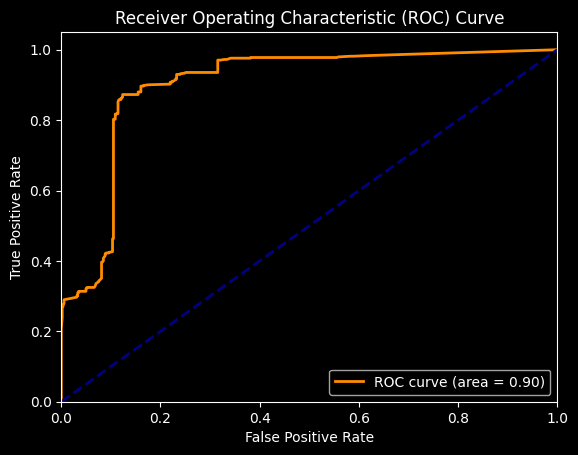

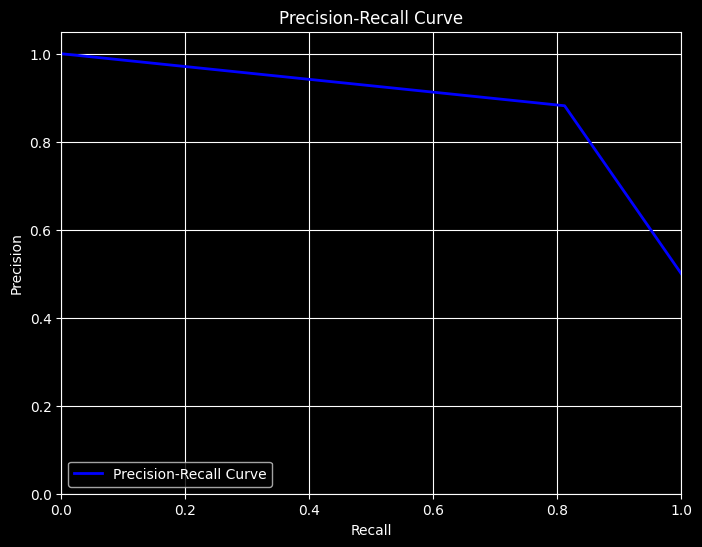

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, precision_recall_curve

# Predict on the training dataset – if we cannot overfit this then we won't be able to classify on Test
y_pred_probs = classifier.predict_proba(Xt)
y_pred_probs = y_pred_probs[:, 1] # Get the probability of class = 1
roc_auc = roc_auc_score(Yt, y_pred_probs)

print("ROC AUC (Test):", roc_auc)

y_pred = classifier.predict(Xt)
classification_report = classification_report(Yt, y_pred)

print("Classification Report (Test):")
print(classification_report)

fpr, tpr, thresholds = roc_curve(Yt, y_pred_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


precision, recall, thresholds = precision_recall_curve(Yt, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


# Large-scale test

In [437]:
df_events = load_flood_events(DATA_DOWNLOAD_DIR, country, subset="test")
df_events.loc[df_events.event_id==4508]

,event_id,start_date,end_date,flood,precip
18,4508,2017-08-10,2017-08-26,./data/Bangladesh/flood/DFO_4508_From_20170810...,./data/Bangladesh/precip/DFO_4508_From_2017081...


In [451]:
download_dir = DATA_DOWNLOAD_DIR
country = REGIONS[0]

df_events = load_flood_events(DATA_DOWNLOAD_DIR, country, subset="test")
row = df_events.loc[df_events.event_id==4508].iloc[0]

base_dir = os.path.join(download_dir, country)
country_geom = load_poly_from_geojson(os.path.join(base_dir, f"{country}.geojson"))
grid_path = os.path.join(base_dir, f"{country}_grid.tif")

hydro_flood_prob_path = os.path.join(base_dir, "derived", "flood_prob_jrc.tif")
hist_flood_prob_path = os.path.join(base_dir, "derived", "flood_prob.tif")
flood_avg_duration_path = os.path.join(base_dir, "derived", "avg_duration.tif")
s1_total_revisit_path = os.path.join(base_dir, "derived", f"s1_revisit_hist_test.tif")

sentinel1_revisit_map = xr.open_dataarray(s1_total_revisit_path, engine="rasterio")
sentinel1_revisit_map = sentinel1_revisit_map.rename({'band':'days'})
average_revisit = get_average_revisit(sentinel1_revisit_map)
    
# Load the flood probability maps and duration
flood_probability = xr.open_dataarray(hist_flood_prob_path, engine="rasterio", chunks={})
hydrological_flood_probability = xr.open_dataarray(hydro_flood_prob_path, engine="rasterio", chunks={})
average_duration = xr.open_dataarray(flood_avg_duration_path, engine="rasterio", chunks={})

with open_on_grid(row['flood'], grid_path, Resampling.max, crop_to=country_geom) as flood_map:
    s1_revisit_event = xr.open_dataarray(os.path.join(base_dir, "sentinel1", f"{row['event_id']}_revisit.tif"), engine="rasterio")
    s1_revisit_event = s1_revisit_event.rename({'band':'days'})
    try:
        s1_last_acq_dates = np.load(os.path.join(base_dir, "sentinel1", f"{row['event_id']}_revisit_prev_acq.npy"))

        revisit_histogram = s1_revisit_event
        last_acquisition_date = s1_last_acq_dates
        avg_revisit = average_revisit
        flood_prob = flood_probability.isel(band=0)
        hydro_flood_prob = hydrological_flood_probability.isel(band=0)
        avg_dur = average_duration.isel(band=0)

        days_since_acq = (np.datetime64(row["start_date"]) - last_acquisition_date).astype("timedelta64[D]") / np.timedelta64(1, "D")
        days_since_acq = np.where(days_since_acq > 20, 20, days_since_acq)
        days_since_acq = np.where(days_since_acq < 0, np.nan, days_since_acq)
        days_since_acq_da = xr.DataArray(days_since_acq, dims=('y', 'x'))

        all_zeros_mask = (revisit_histogram == 0).all(dim='days')
        revisit_histogram = revisit_histogram.where(~all_zeros_mask, 1)

        def wrapper_func(histogram, days_since_acq):
            return compute_prob_of_acq_today(histogram, days_since_acq)

        prob_of_acq_da = xr.apply_ufunc(
            wrapper_func,
            revisit_histogram,
            days_since_acq_da,
            input_core_dims=[['days'], []],
            output_core_dims=[[]],
            vectorize=True,
            dask='parallelized',
            output_dtypes=[float]
        )

        prob_of_acq_da = prob_of_acq_da.assign_coords({'y': revisit_histogram['y'], 'x': revisit_histogram['x']})
        prob_of_acq_da.attrs = revisit_histogram.attrs

        days_since_acq_da = days_since_acq_da.assign_coords({'y': revisit_histogram['y'], 'x': revisit_histogram['x']})
        days_since_acq_da.attrs = revisit_histogram.attrs

        stack_dim = 'feature'
        stacked_data = xr.concat([
            prob_of_acq_da.expand_dims({stack_dim: 1}),
            days_since_acq_da.expand_dims({stack_dim: 1}),
            avg_revisit.expand_dims({stack_dim: 1}),
            flood_prob.expand_dims({stack_dim: 1}),
            hydro_flood_prob.expand_dims({stack_dim: 1}),
            avg_dur.expand_dims({stack_dim: 1})
        ], dim=stack_dim)
    finally:
        s1_revisit_event.close()        
        sentinel1_revisit_map.close()
        flood_probability.close()
        hydrological_flood_probability.close()
        average_duration.close()

In [454]:
stacked_data.rio.to_raster(os.path.join(base_dir, "full_test_scene.tif"))

# Chunk the data for parallel processing with Dask
stacked_data = stacked_data.chunk({'feature': 6, 'y':1, 'x':1}).compute()

## Run the trained classifier over the entire region

In [487]:
def predict_pixel(pixel_features, model):
    pred_proba = model.predict_proba(pixel_features.reshape(1, -1))
    return pred_proba[0, 1]

def wrapper_predict(fts):
    return predict_pixel(fts, classifier)

predicted_proba = xr.apply_ufunc(
    wrapper_predict,
    stacked_data,
    input_core_dims=[['feature']],  
    output_core_dims=[[]],  
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

predicted_proba.compute()


In [491]:
predicted_proba.rio.to_raster(os.path.join(base_dir, "full_test_scene_predictions.tif"))

Text(0.5, 1.0, 'Probability of S1 Acquisition within 24hrs from 10 Aug 2017')

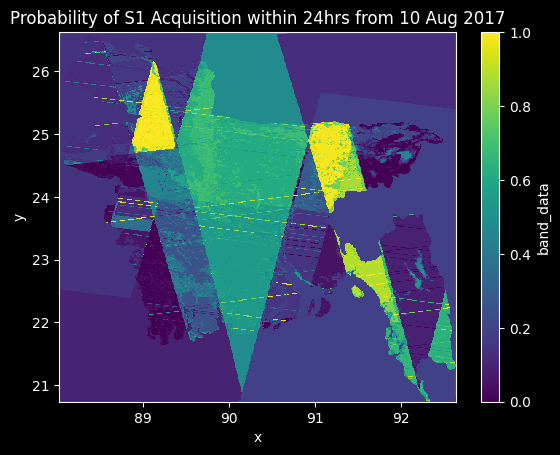

In [7]:
import os
import xarray as xr
import rioxarray as rxr

res = xr.open_dataarray(os.path.join(DATA_DOWNLOAD_DIR, REGIONS[0], "full_test_scene_predictions.tif"), engine='rasterio')
res.plot()
plt.title("Probability of S1 Acquisition within 24hrs from 10 Aug 2017")